<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/CIFAR-10-ResNet20-Vs-Inception/ResNet20_Inception_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# Load `CIFAR10`

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"X Train Shape: {x_train.shape}")
print(f"Y Train Shape: {y_train.shape}")
print(f"X Test Shape: {x_test.shape}")
print(f"Y Test Shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X Train Shape: (50000, 32, 32, 3)
Y Train Shape: (50000, 1)
X Test Shape: (10000, 32, 32, 3)
Y Test Shape: (10000, 1)


# Check Samples Per Class

In [3]:
unique_labels = np.unique(y_train)
print(f"Unique numerical labels in y_train: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}\n")

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

Unique numerical labels in y_train: [0 1 2 3 4 5 6 7 8 9]
Number of unique labels: 10

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


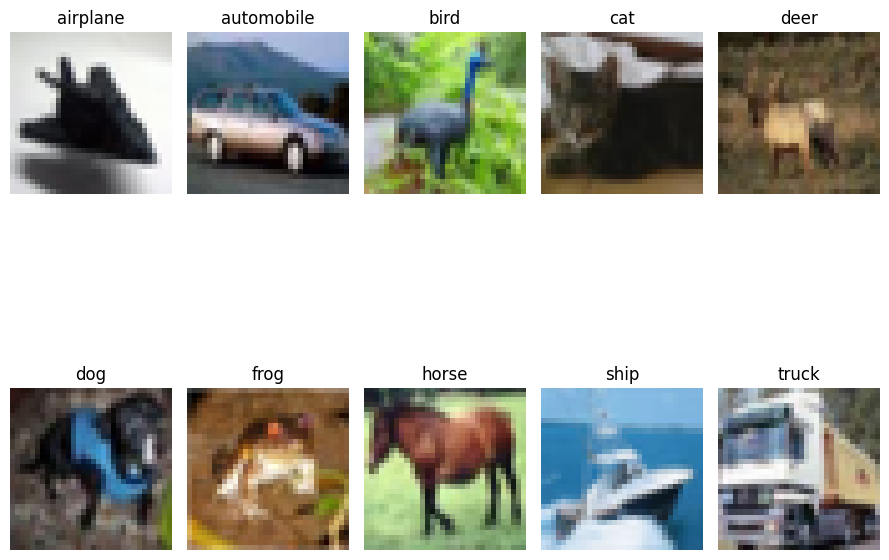

In [4]:
# Plot samples
plt.figure(figsize=(9, 9))
for i, class_label in enumerate(unique_labels):
    idx = np.where(y_train == class_label)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[class_label])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Preprocessing

## Normalization

In [5]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print(f"X train normalized shape: {x_train.shape} | Min: {np.min(x_train)} | Max: {np.max(x_train)}")
print(f"X test normalized shape: {x_test.shape} | Min: {np.min(x_test)} | Max: {np.max(x_test)}")

X train normalized shape: (50000, 32, 32, 3) | Min: 0.0 | Max: 1.0
X test normalized shape: (10000, 32, 32, 3) | Min: 0.0 | Max: 1.0


## Creating Data Pipeline

In [6]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Create tf.data.Dataset train dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                        .shuffle(len(x_train)) \
                        .batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create tf.data.Dataset train dataset
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
                        .batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"Train dataset shape: {train_ds.element_spec}")
print(f"Test dataset shape: {test_ds.element_spec}")

Train dataset shape: (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))
Test dataset shape: (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))


In [7]:
# Demonstrate iterating through a batch from the training dataset
for images, labels in train_ds.take(1):
    print(f"Shape of images in a training batch: {images.shape}")
    print(f"Shape of labels in a training batch: {labels.shape}")

# Demonstrate iterating through a batch from the test dataset
for images, labels in test_ds.take(1):
    print(f"Shape of images in a test batch: {images.shape}")
    print(f"Shape of labels in a test batch: {labels.shape}")

Shape of images in a training batch: (64, 32, 32, 3)
Shape of labels in a training batch: (64, 1)
Shape of images in a test batch: (64, 32, 32, 3)
Shape of labels in a test batch: (64, 1)


# ResNet20 Model Definition

In [8]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [9]:
# Define Basic Block
def basic_block(x, filters, stride=1):
    shortcut = x

    # 1st Conv
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding="same",
                      kernel_initializer="he_normal",
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 2nd Conv
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same",
                      kernel_initializer="he_normal",
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Shortcut
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False,
                                 kernel_initializer="he_normal",
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-4))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Concatenate x and shortcut
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


def stage(x, filters, num_blocks, stride=1):
    x = basic_block(x, filters, stride)
    for _ in range(1, num_blocks):
        x = basic_block(x, filters, stride)
    return x


def build_resnet20(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Stem
    x = layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same",
                      kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    filter_size = [16, 32, 64]
    strides = [1, 2, 2]
    blocks = [3 , 3, 3]
    for filter, stride, block in zip(filter_size, strides, blocks):
        x = stage(x, filter, block, stride)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

## Build Model

In [10]:
model_resnet = build_resnet20(input_shape=(32, 32, 3), num_classes=10)

# compiling the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4)
model_resnet.compile(
    optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model_resnet.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        448 │ sequential[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,320 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,320 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ re_lu_2[0][0],    │
│                     │ 16)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,320 │ re_lu_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      2,320 │ re_lu_4[0][0]   

 Total params: 285,738 (1.09 MB)

 Trainable params: 283,786 (1.08 MB)

 Non-trainable params: 1,952 (7.62 KB)

## Training

In [11]:
# Define Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.1, patience=10, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=20, restore_best_weights=True)
]


# Training
history_resnet = model_resnet.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.2658 - loss: 2.2759 - val_accuracy: 0.3624 - val_loss: 1.9523 - learning_rate: 0.1000
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.4345 - loss: 1.7848 - val_accuracy: 0.3993 - val_loss: 1.8832 - learning_rate: 0.1000
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.4906 - loss: 1.6011 - val_accuracy: 0.4477 - val_loss: 1.9642 - learning_rate: 0.1000
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.5335 - loss: 1.4927 - val_accuracy: 0.5443 - val_loss: 1.5248 - learning_rate: 0.1000
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.5764 - loss: 1.3886 - val_accuracy: 0.5139 - val_loss: 1.6217 - learning_rate: 0.1000
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.5892 - loss: 1.3513 - val_accuracy: 0.5947 - val_loss: 1.3683 - learning_rate: 0.1000
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6

## Evaluation

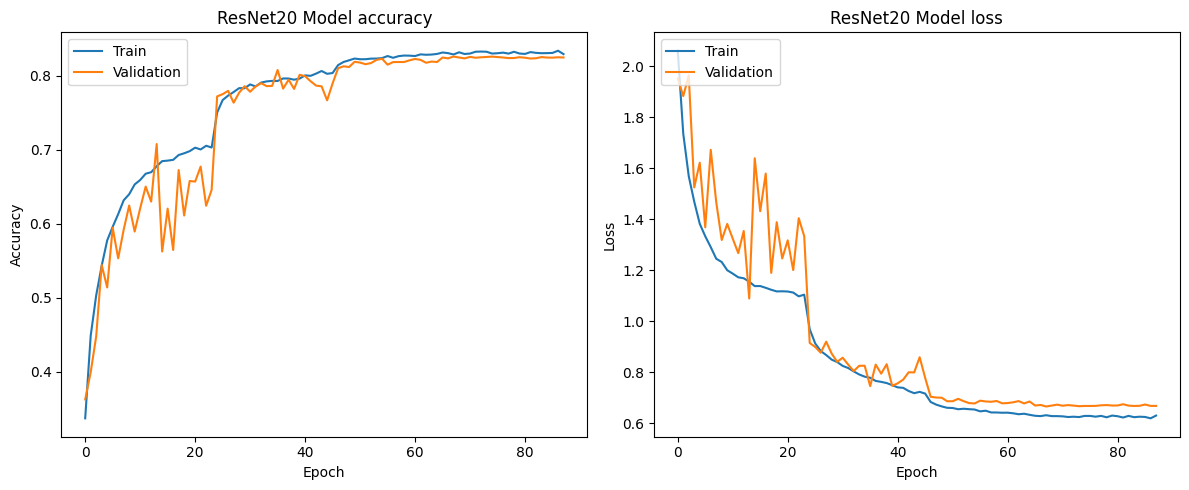

In [12]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot history for ResNet model
plot_history(history_resnet, 'ResNet20')

# Inception Model Definition

In [13]:
def conv_bn_relu(x, filters, kernel_size, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Inception Block
def inception_block(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Inception V1 block.
    filters_1x1  = #filters 1x1 branch
    filters_3x3_reduce = #filters 1x1 before 3x3 branch
    filters_3x3  = #filters 3x3
    filters_5x5_reduce = #filters 1x1 before 5x5 branch
    filters_5x5  = #filters 5x5
    filters_pool_proj  = #filters 1x1 projection after pooling branch
    """
    # Branch 1
    b1 = conv_bn_relu(x, filters_1x1, 1)

    # Branch 2
    b2 = conv_bn_relu(x, filters_3x3_reduce, 1)
    b2 = conv_bn_relu(b2, filters_3x3, 3) # Corrected: applied to b2, not x initially

    # Branch 3
    b3 = conv_bn_relu(x, filters_5x5_reduce, 1)
    b3 = conv_bn_relu(b3, filters_5x5, 5)

    # Branch 4
    b4 = layers.MaxPooling2D(3, strides=1, padding="same")(x)
    b4 = conv_bn_relu(b4, filters_pool_proj, 1)

    # Concatenate
    return layers.Concatenate(axis=-1)([b1, b2, b3, b4]) # Used layers.Concatenate

def build_inception(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Stem
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Inception Mod 1
    x = inception_block(x,
                         filters_1x1=32,
                         filters_3x3_reduce=32, filters_3x3=48,
                         filters_5x5_reduce=8, filters_5x5=16,
                         filters_pool_proj=16)
    x = layers.MaxPooling2D((2, 2))(x)

    # Inception Mod 2
    x = inception_block(x,
                         filters_1x1=64,
                         filters_3x3_reduce=64, filters_3x3=96,
                         filters_5x5_reduce=16, filters_5x5=32,
                         filters_pool_proj=32)
    x = layers.MaxPooling2D((2, 2))(x) # Corrected: MaxPoolin2D -> MaxPooling2D

    # Inception Mod 3
    x = inception_block(x,
                         filters_1x1=128,
                         filters_3x3_reduce=96, filters_3x3=128,
                         filters_5x5_reduce=32, filters_5x5=48,
                         filters_pool_proj=64)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name='Mini_Inception')
    return model

## Build & Compile

In [14]:
model_inception = build_inception(input_shape=(32, 32, 3), num_classes=10)

decay_steps = 100 * len(train_ds)
# Define the CosineDecay learning rate schedule
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps, alpha=0.001)

# compiling the model with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
model_inception.compile(
    optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model_inception.summary()

Model: "Mini_Inception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32, 32, 3) │          0 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │        896 │ sequential[1][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │      1,056 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32, 8) │        264 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │      1,056 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │     13,872 │ re_lu_29[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │      3,216 │ re_lu_31[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │        528 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 337,794 (1.29 MB)

 Trainable params: 335,826 (1.28 MB)

 Non-trainable params: 1,968 (7.69 KB)

## Training

In [15]:
# Define Callbacks (removing CosineDecay from here)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=20, restore_best_weights=True)
]

# Training
history_inception = model_inception.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.3422 - loss: 1.8444 - val_accuracy: 0.4664 - val_loss: 1.5697
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.5545 - loss: 1.2437 - val_accuracy: 0.5016 - val_loss: 1.5687
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6203 - loss: 1.0685 - val_accuracy: 0.6106 - val_loss: 1.1506
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.6578 - loss: 0.9642 - val_accuracy: 0.5731 - val_loss: 1.2161
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6868 - loss: 0.8829 - val_accuracy: 0.6383 - val_loss: 1.0585
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.7049 - loss: 0.8414 - val_accuracy: 0.6148 - val_loss: 1.2729
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.7247 - loss: 0.7938 - val_accuracy: 0.6623 - val_loss: 1.0812
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.7363 - loss: 0

## Evaluation

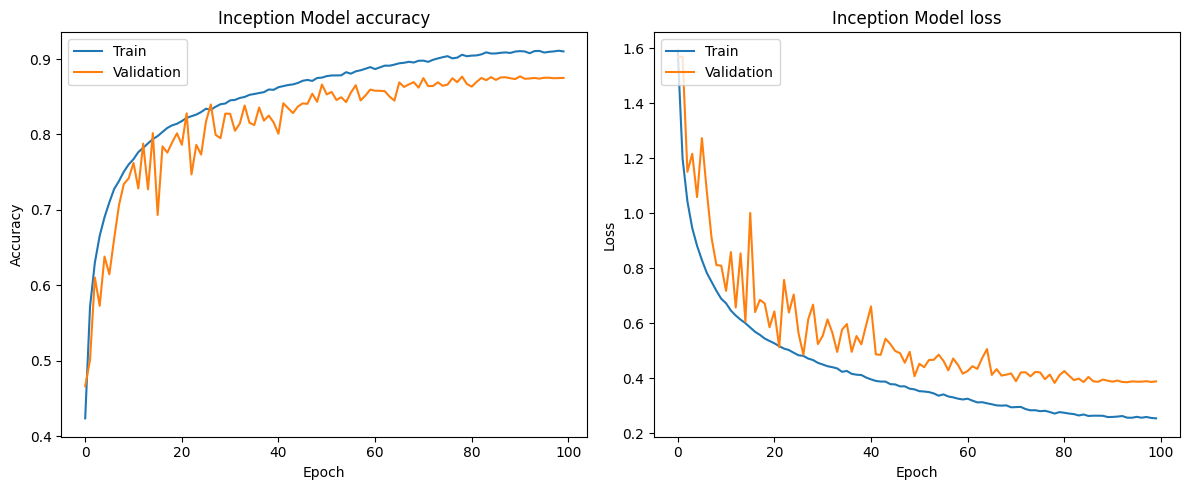

In [16]:
# Plot history for Inception model
plot_history(history_inception, 'Inception')

# `ResNet20` Vs `Inception` Comparison

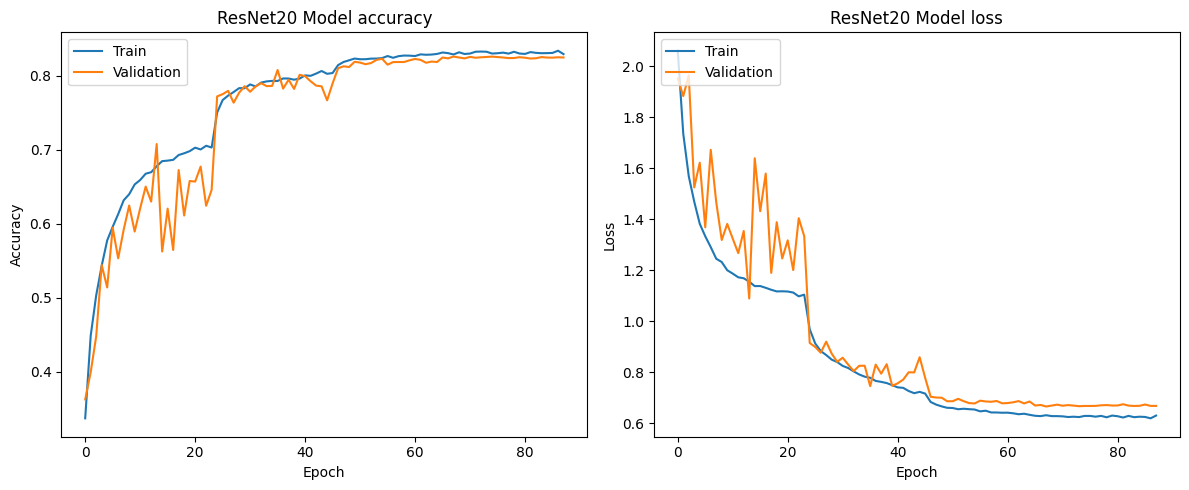

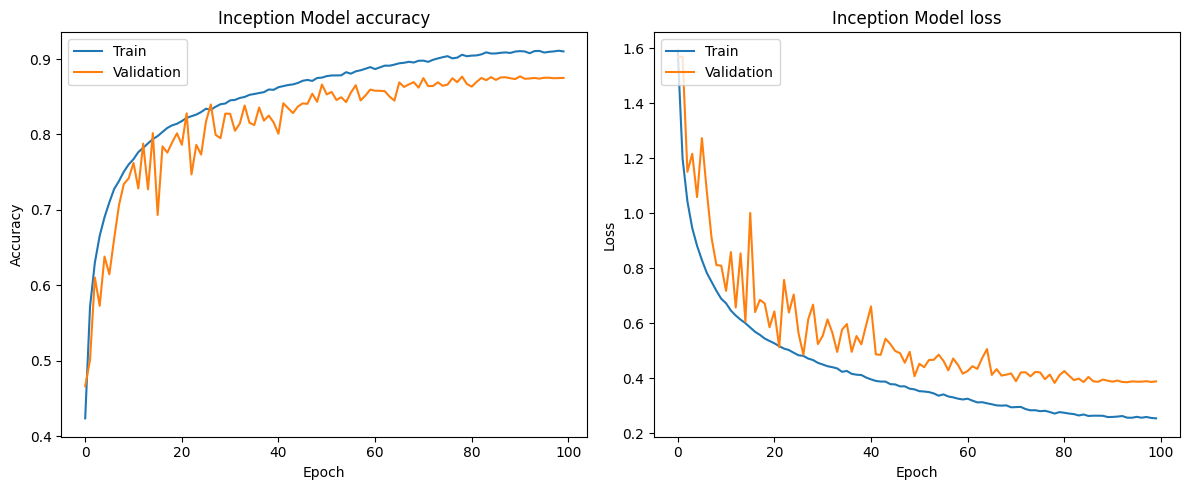

In [17]:
plot_history(history_resnet, 'ResNet20')
plot_history(history_inception, 'Inception')